In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import RK45
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from celluloid import Camera
from multiprocessing import Pool
from os import cpu_count

plt.rcParams['image.cmap'] = 'magma'

In [6]:
def coefficients_matrix(N: int):
    M = np.zeros((N-2, N))
    for i in range(1, N-3):
        M[i, i-1:i+4] = (-1/12, 4/3, -5/2, 4/3, -1/12)
    M[0, :3] = M[-1, -3:] = (1, -2, 1)
    return M

class Grid:
    def __init__(self, xl, xr, dx=None, N=None):
        assert (dx != None or N != None)
        self.xl, self.xr = xl, xr
        if dx != None:
            self.dx = dx
            self.N = int((xr - xl)/dx)
        elif N != None:
            self.dx = (xr - xl)/N
            self.N = N
        self.x = np.arange(self.xl, self.xr, self.dx)

class HyperProblem:
    def __init__(self, grid, h, f, g):
        self.grid = grid
        self.h = h
        self.Y0 = np.stack((
            f(grid.x[1:-1]),
            g(grid.x[1:-1])
        ))
        M = coefficients_matrix(grid.N)/grid.dx**2
        self.M = M[:, 1:-1]
        self.M0 = np.zeros(grid.N - 2)
        self.M0[:2] = M[:2, 0]*f(grid.xl)
        self.M0[-2:] = M[-2:, -1]*f(grid.xr)
        
    def d2y_dx2(self, t, y):
        return self.M0 + self.M.dot(y) + self.h(self.grid.x[1:-1], t, y)

    def F(self, t, Y):
        y, dy_dt = Y
        return np.stack((dy_dt, self.d2y_dx2(t, y)))

class RKSolver:
    def __init__(self, t0, dt, hproblem):
        self.dt = dt
        self.F = hproblem.F
        self._Y = [hproblem.Y0]
        self._t = [t0]

    def step(self):
        t = self._t[-1]
        y = self._Y[-1]
        dt = self.dt

        k1 = self.F(t, y)
        k2 = self.F(t + dt/2, y + k1*dt/2)
        k3 = self.F(t + dt/2, y + k2*dt/2)
        k4 = self.F(t + dt, y + k3*dt)

        self._Y.append(
            y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        )
        self._t.append(t + dt)

    def run_util(self, T):
        while self._t[-1] < T:
            self.step()

    @property
    def Y(self):
        return np.stack(self._Y)

    @property
    def t(self):
        return np.stack(self._t)

def kink_antikink(x0, v, lamb):
    try: len(v)
    except TypeError: 
        v1 = v
        v2 = -v
    else: v1, v2 = v
    finally:
        g1 = 1/(1 - v1**2)**0.5
        g2 = 1/(1 - v2**2)**0.5
        delta = (2/lamb)**0.5
        c1 = g1/delta
        c2 = g2/delta
        return (
            lambda x, t, y: lamb*y*(1 - y**2),
            lambda x: np.tanh((x + x0)*c1) - np.tanh((x - x0)*c2) - 1,
            lambda x: - c1*v1/np.cosh((x + x0)*c1)**2 + c2*v2/np.cosh((x - x0)*c2)**2
        )

In [7]:
grid = Grid(-40, 40, N=1000)

CPU times: user 17.3 s, sys: 20.4 s, total: 37.7 s
Wall time: 4.78 s


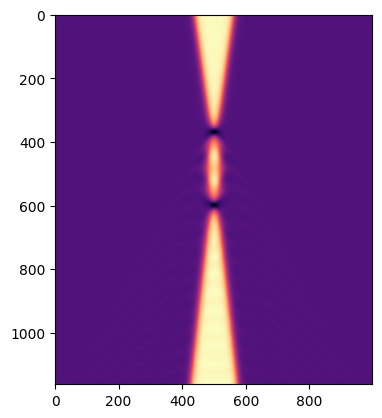

In [101]:
%%time
v = 0.2
x0 = 5
lamb = 2
solver = RKSolver(0, grid.dx*0.7, HyperProblem(grid, *kink_antikink(x0, v, lamb)))
solver.run_util(x0/v + grid.xr)
plt.imshow(solver.Y[:, 0])

CPU times: user 15.2 s, sys: 19.6 s, total: 34.8 s
Wall time: 4.42 s


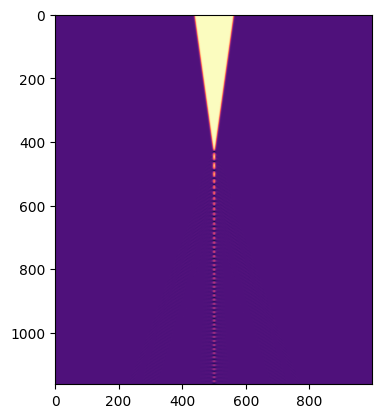

In [105]:
%%time
v = 0.2
x0 = 5
lamb = 50
solver = RKSolver(0, grid.dx*0.7, HyperProblem(grid, *kink_antikink(x0, v, lamb)))
solver.run_util(x0/v + grid.xr)
plt.imshow(solver.Y[:, 0])

$$
2x_0 \gg \delta = \sqrt{2/\lambda}
$$

$$
4x_0^2 \gg 2/\lambda
$$

$$
\lambda \gg \frac{1}{2x_0^2} = \frac{1}{2(5)^2} = \frac{1}{50} = 0.02
$$

In [120]:
pd.DataFrame(solver.Y[:, 0], columns=grid.x[1:-1], index=solver.t)

,-39.92,-39.84,-39.76,-39.68,-39.60,-39.52,-39.44,-39.36,-39.28,-39.20,...,39.12,39.20,39.28,39.36,39.44,39.52,39.60,39.68,39.76,39.84
0.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.056,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.112,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.168,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.224,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64.792,-0.999979,-0.999965,-0.999963,-0.999971,-0.999986,-1.000004,-1.000017,-1.000026,-1.000028,-1.000025,...,-1.000042,-1.000040,-1.000025,-1.000003,-0.999984,-0.999973,-0.999973,-0.999980,-0.999989,-0.999996
64.848,-0.999997,-0.999991,-0.999983,-0.999976,-0.999975,-0.999985,-1.000002,-1.000023,-1.000037,-1.000039,...,-1.000039,-1.000034,-1.000014,-0.999990,-0.999974,-0.999974,-0.999987,-1.000004,-1.000015,-1.000012
64.904,-1.000015,-1.000019,-1.000009,-0.999991,-0.999977,-0.999975,-0.999988,-1.000010,-1.000029,-1.000034,...,-1.000016,-1.000011,-0.999997,-0.999983,-0.999979,-0.999988,-1.000007,-1.000024,-1.000030,-1.000021
64.960,-1.000023,-1.000034,-1.000029,-1.000011,-0.999991,-0.999979,-0.999981,-0.999993,-1.000006,-1.000011,...,-0.999982,-0.999980,-0.999981,-0.999986,-0.999997,-1.000011,-1.000024,-1.000031,-1.000029,-1.000017


In [19]:
from pathlib import Path
import pandas as pd
data_dir = Path('../data/mosaico')

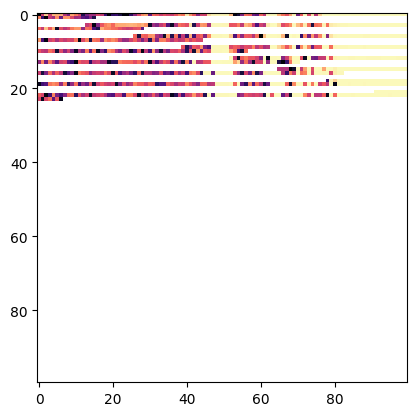

In [21]:
plt.imshow(pd.read_csv(data_dir/'mosaic.csv', index_col=0).values)

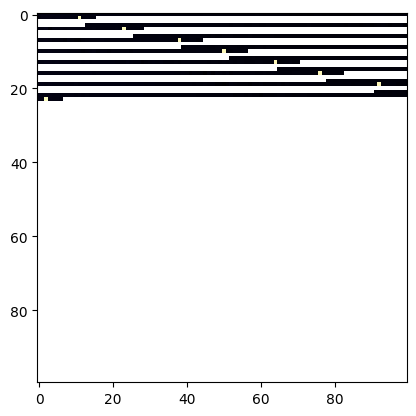

In [22]:
plt.imshow(pd.read_csv(data_dir/'exec_time.csv', index_col=0).values)

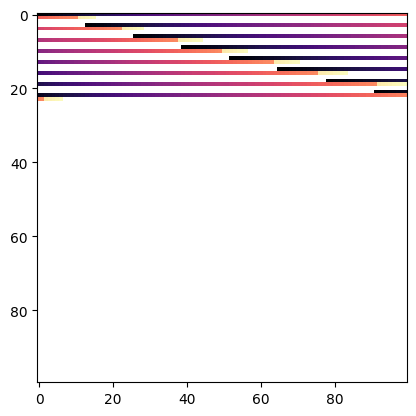

In [23]:
plt.imshow(pd.read_csv(data_dir/'ell_time.csv', index_col=0).values)